# BART Sequence Programming, Simulation, Reconstruction

Based off of previous tutorials from other contributors:  

1. [MRITogether 2023 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2023), [Jon Tamir](mailto:jtamir@utexas.edu), Chandra Family Department of Electrical and Computer Engineering, The University of Texas at Austin
2. [MRITogether 2021 Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/mri_together_2021), [Martin Uecker](mailto:uecker@tugraz.at)$^{\dagger}$, Nick Scholand, Moritz Blumenthal, Xiaoqing Wang, $^{\dagger}$ Graz University of Technology
3. [BART Webinar 1 Tutorial](https://github.com/mrirecon/bart-webinars/tree/master/webinar1), [Max Litster](mailto:maxlitster@berkeley.edu), UC Berkeley
4. [Open MR Days 2025 Workshop](https://github.com/mrirecon/bart-workshop/tree/master/dach_ismrm2025), [Martin Uecker](mailto:uecker@tugraz.at), [Daniel Mackner](mailto:daniel.mackner@tugraz.at), [Vitali Telezki](mailto:vitali.telezki@med.uni-goettingen.de)


The purpose of this notebook is to introduce some new features of the [BART toolbox](https://mrirecon.github.io/bart), and its use as a tool for reproducible research in MRI.

We recommend checking other points of reference, primarily available in the following locations:
- [BART Workshops](https://github.com/mrirecon/bart-workshop)
- [BART Webinars](https://github.com/mrirecon/bart-webinars) (and [webinar recordings](https://www.youtube.com/@bart-toolboxdepartmental7435/playlists)\)


### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `BART_TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export BART_TOOLBOX_PATH=/path/to/bart  
export PATH=$BART_TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$BART_TOOLBOX_PATH/matlab` and `$BART_TOOLBOX_PATH/python` directories.

### Online Usage
We recommend running BART locally when possible. For demonstration purposes, MyBinder and Google Colaboratory can be used to access a Jupyter instance with BART with a browser. In the following we install and configure BART for both.

The following code will automatically detect which service you are using.

In [1]:
# Check if notebook runs on colab
import sys, os

os.environ['COLAB'] = 'true' if ('google.colab' in sys.modules) else 'false'

#### BART Installation

Here we install BARTs dependencies, clone its repository from github, and compile it.

Check BART setup:

In [2]:
%%bash

# MyBinder has BART already installed via the container
if $COLAB; then

  # Install BARTs dependencies
  apt-get install -y -qq make gcc-12 g++-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev

  # Clone Bart
  [ -d /content/bart ] && rm -r /content/bart
  git clone -q https://github.com/mrirecon/bart/ bart
fi

In [3]:
%%bash

if $COLAB; then

cd bart

# Configuration
cat > Makefile.local <<HERE
PARALLEL=1
CUDA=0
CUDA_BASE=/usr/local/cuda
CUDA_LIB=lib64
OPENBLAS=1
BLAS_THREADSAFE=1
CC=gcc-12
HERE

# Compile BART
make --silent && echo ok
fi

#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside an ipyhton jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [4]:
if os.environ['COLAB'] == 'true':
    os.environ['BART_TOOLBOX_PATH'] = "./bart"
    os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']

# Make BART python wrappers available:
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
# Sensible number of threads for multithreading in BART
os.environ['OMP_NUM_THREADS'] = "4"

In [5]:
%%bash
echo "# BART version: "
bart version

# BART version: 
v0.9.00-1413-g88bade9


### Setup Visualization Helper

For this tutorial we will visualize some images. Therefore, we need a helper function and some python libraries.


In [6]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def show_img(data, title=None, vmin=None, vmax=None, cmap='gray', cbar_label='', mag=True, fsize=10, \
             interpolation='bilinear', cbar=False):

    # Import data
    data = np.abs(data) if mag else data

    fig = plt.figure(figsize=(fsize,fsize))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation=interpolation, cmap=cmap, vmin=vmin, vmax=vmax)
    if title:
      plt.title(title)
    # Style settings
    if cbar:
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(cbar_label)
        cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()

    plt.show()


def plot_mom_from_cfl(name, end=-1, ylim=-1, ylabel="moment / sT/m"):
    """Plot three axes from a BART cfl"""

    if not os.path.exists(name + '.cfl'):
        FileNotFoundError(f"{name + '.cfl'} does not exist")
    if not os.path.exists(name + '.hdr'):
        FileNotFoundError(f"{name + '.hdr'} does not exist")

    data = np.array(cfl.readcfl('./' + name))
    time_points=np.linspace(0, 1, np.shape(data)[1])
    xlabel = "time / a.u."
    if 0 < end:
        time_points=np.linspace(0, end, np.shape(data)[1])
        xlabel = "time / s"

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i in range(3):
        ax[i].plot(time_points, np.real(data[i,:]))
        ax[i].set_xlabel(xlabel)

    ax[0].set_ylabel(ylabel)

    titles = ['PE', 'RO', 'SL']
    
    for i in range(3):
        ax[i].grid()
        if ylim > 0:
            ax[i].set_ylim(-ylim,ylim)
        ax[i].set_title(titles[i])
    

def plot_grad_from_cfl(name, end=-1):
    """Plot three axes from a BART cfl"""

    plot_mom_from_cfl(name, end, 25e-3, ylabel="gradient T/m")

## BART Fundamentals
BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.



In [7]:
# get a list of BART commands by running bart with no arguments:
! bart

BART. Type `bart <command> -h` for options.
Basic Tools: bitmask     casorati    circshift   compress    copy        crop        delta       
             extract     flatten     flip        index       join        multicfl    ones        
             poly        repmat      reshape     resize      show        slice       squeeze     
             tee         transpose   trx         vec         version     zeros       
Mathematics: avg         cabs        calc        carg        cdf97       conj        cpyphs      
             creal       fmac        invert      mip         normalize   nrmse       pattern     
             saxpy       scale       sdot        spow        unwrap      zexp        
Numerics:    bench       conv        conway      fft         fftmod      fftrot      fftshift    
             filter      gmm         hist        mandelbrot  morphop     nlmeans     noise       
             pol2mask    roistat     rss         std         threshold   var         wavelet     


### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by carrot symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [8]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

## Simulation with BART
###  BART Sequence

We can simulate a sequence with the *seq*-command. By default, a GRE (RF random spoiled) imaging block is computed.

If we do not modify the sequence parameters via the commandline-interface, a default sequence configuration is used.
Parameters can be found in *bart*: src/seq/config.c


**Additional info (debug print)**:

Sequence blocks are composed from three types of events, namely RF pulses, ADCs, and gradients, all parametrized by start-, mid- and endtime. Gradients are further defined by an amplitude for all three directions. Both, RF and ADC-events, include phase and frequency information, enabling slice-shifted excitation and FOV-shifted acquisition. RF events are mapped to a pulse shape and ADCs are described by dwelltime, samples and position.




In [9]:
! BART_DEBUG_LEVEL=5 bart seq -r 3 --TE 2e-3 --TR 3.5e-3 --FOV 0.256 --BR 256 adc grad moments

Builtin found: seq
Enter BART loop_step: start=0 idx=-1, idx_p=-1, final_ret=0.
BART loop_step order:
 [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Leave BART loop_step: start=0 idx=0, idx_p=0, final_ret=0.

Set total number of spokes to 3 (full frame for RAGA encoding)
loops: 81 	 dims: [  1   3   1   1   1   1   3   3   3   1   1   1   1   1   1   1 ]
kernels: 3 	 dims: [  1   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1
RF pulse 0: scale = 6.000000, sum = 165.077466
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 ]
seq_block_end_flat: -0.000000
[  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0 ]
block mode: 4 ; E: 13 
event[0]:	0.00000000		0.00018900		0.00080900		||	0.00000		0.00000		0.02399
event[1]:	0.00018900		0.00080900		0.00099732		||	0.00000		0.00000		0.02399
event[2]:	0.00099732		0.00115178		0.00182553		||	-0.00000		-0.00000		-0.01171
event[3]:	0.00115178		0.00182553		0.00198000		||	-0.00000		-0.000

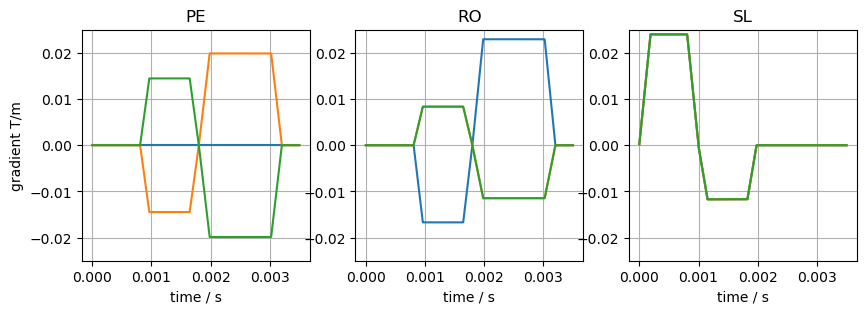

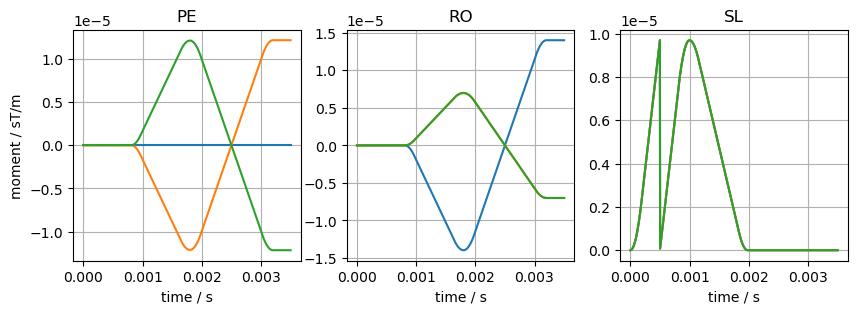

In [10]:
plot_grad_from_cfl('grad', 3.5e-3)
plot_mom_from_cfl('moments', 3.5e-3)

### Non-Cartesian trajectory

For the acquisition of an image we acquire multiple radial spokes.
The *seq*-command provides us also with relevant information for the reconstruction, such as ADC timings/phase and the k-space trajectory.



In [11]:
%%bash
bart seq -r377 --raga adc grad moments

bart show -m adc

bart extract 0 0 3 adc seq_traj

# bart traj -x 256 -o 2. -y 377 -r -D trj_ref
# bart nrmse trj_ref seq_traj_lin

Set total number of spokes to 377 (full frame for RAGA encoding)
loops: 1279161 	 dims: [  1 377   1   1   1   1   3   3 377   1   1   1   1   1   1   1 ]
kernels: 377 	 dims: [  1 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1


Type: complex float
Dimensions: 16
AoD:	5	512	377	1	1	1	1	1	1	1	1	1	1	1	1	1


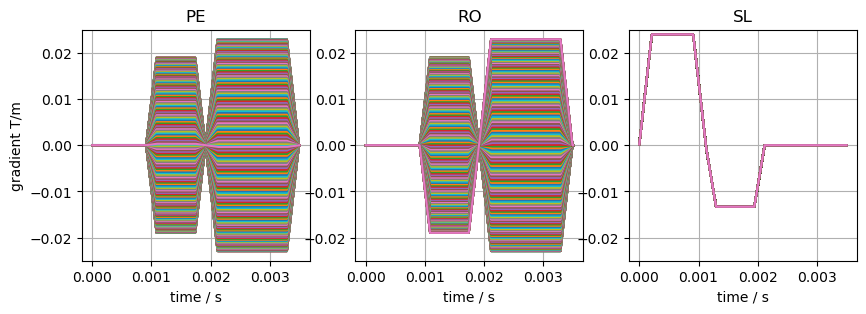

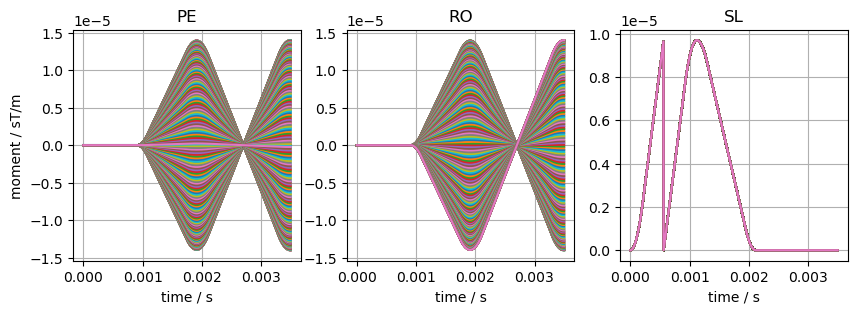

In [12]:
plot_grad_from_cfl('grad', 3.5e-3)
plot_mom_from_cfl('moments', 3.5e-3)

### Phantom simulation 

First, we perform Bloch simulations on for different tissues.

In this example we vary T1 resulting in 11 different signals.

In order to obtain a sufficient T1w contrast, we acquire multiple repetitions to have the signal in a steady-state.


In [13]:
%%bash

# Simulation Parameters
#       Run `bart sim --seq h` for more details
TR=0.0035       # Repetition Time [s]
TE=0.0021       # Echo Time [s]
REP=600         # Number of repetitions

bart sim --ODE --seq FLASH,TR=$TR,TE=$TE,Nrep=$REP,FA=10 -1 0.1:2:11 -2 1:1:1 simu_rep

bart slice 5 $((REP-1)) simu_rep simu


0.169511


Additional: explicitly defining the numerical phantom parameters.

In [14]:
%%bash

# # Simulation Parameters
# #       Run `bart sim --seq h` for more details
# TR=0.0035       # Repetition Time [s]
# TE=0.0021       # Echo Time [s]
# REP=600         # Number of repetitions

# # Relaxation parameters for Brain phantom
# T1=(3 2.0 1.8 1.6 1.4 1.2 1.0 0.8 0.6 0.4 0.2)
# T2=(0.2  0.125  0.105  0.085  0.065 0.055 0.045 0.035 0.025 0.015 0.01)
# Run Simulations
# for i in `seq 0 10`; do

# 	bart sim --ODE --seq FLASH,TR=$TR,TE=$TE,Nrep=$REP,FA=8 -1 ${T1[$i]}:${T1[$i]}:1 -2 ${T2[$i]}:${T2[$i]}:1 - |\
# 	bart slice 5 $((REP-1)) - tmp_simu$(printf "%02d" $i)
# done
# bart join 6 $(ls tmp_simu*.cfl | sed -e 's/\.cfl//') simu

For the acquisition of an image we acquire multiple radial spokes.

Using the `phantom`-tool and the `seq`-provided trajectory, we create an artificial k-space

Combining simulated signal and basis geometries to a numerical k-space phantom can be achieved with the `phantom` tool in combination with the `-b` flag.


A detailed intro can be found on the [ISMRM 2023 BART secret session on Digital Objects and Synthetic MRI with BART](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2023/digital-objects/digital-objects.ipynb).


In [15]:
%%bash

bart phantom -k -T -b -t seq_traj basis_geom
bart fmac -s $(bart bitmask 6) basis_geom simu ksp


And perform a simple reconstruction (one coil, inverse NUFFT)

Est. image size: 256x256x1


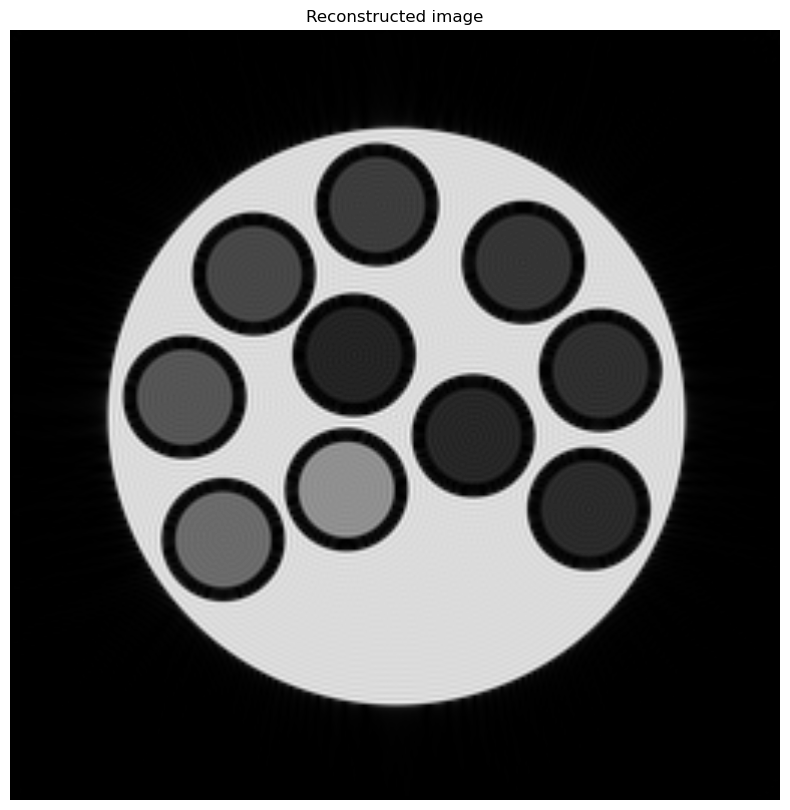

In [16]:
! bart nufft -i -t seq_traj ksp img
show_img(cfl.readcfl('img'), title='Reconstructed image')

### FOV shifts

The `seq`-command provides us also with relevant information for the reconstruction, such as ADC timings/phase.

With the ADC timing and the phase information,
we can also simulate (and validate) FoV shifts of our sequence by checking the phase of each ADC sample.

(For this purpose, we have to turn off RF spoiling.)

Set total number of spokes to 377 (full frame for RAGA encoding)
loops: 1279161 	 dims: [  1 377   1   1   1   1   3   3 377   1   1   1   1   1   1   1 ]
kernels: 377 	 dims: [  1 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1
Est. image size: 256x256x1


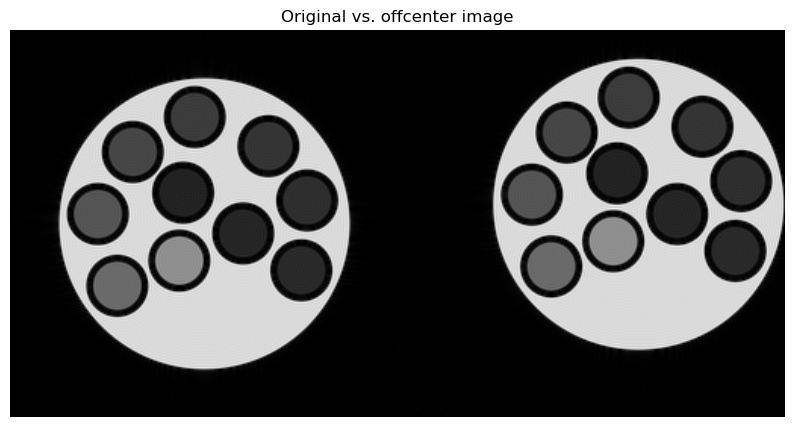

In [17]:
! bart seq -r377 -S 0.05:-0.12:0 --no-spoiling adc grad moments
! bart slice 0 4 adc adc_phase
! bart fmac adc_phase ksp ksp_offcenter

! bart nufft -i -t seq_traj ksp_offcenter img_offcenter

! bart join 1 img img_offcenter img_off

show_img(cfl.readcfl('img_off'), title='Original vs. offcenter image')


### Affine registration

Now, we try to estimate the rigid-body motion between these two images and correct for the shifts and check if we can recover the ground truth.


A detailed intro can be found on the [ISMRM 2024 Workshop Motion Correction ](https://github.com/mrirecon/bart-workshop/tree/master/ismrm_motion_2024).


In [18]:
! bart affinereg  img img_offcenter affine_matrix
! bart slice 1 3 affine_matrix shift


Affine Transform Matrix:
  +1.00e+00  +5.17e-05  +0.00e+00  -4.99e-02
  -5.17e-05  +1.00e+00  +0.00e+00  +1.20e-01
  +0.00e+00  +0.00e+00  +1.00e+00  +0.00e+00


With `fovshift` we can correct translational motion by shifting the FOV retrospectively in k-space based on the estimated motion affine parameters.

For rotation, we refer to the motion tutorial.

In [19]:
! bart fovshift -S shift -t seq_traj ksp_offcenter ksp_corr

In [20]:
! bart nufft -i -t seq_traj ksp_corr img_corr


Est. image size: 256x256x1


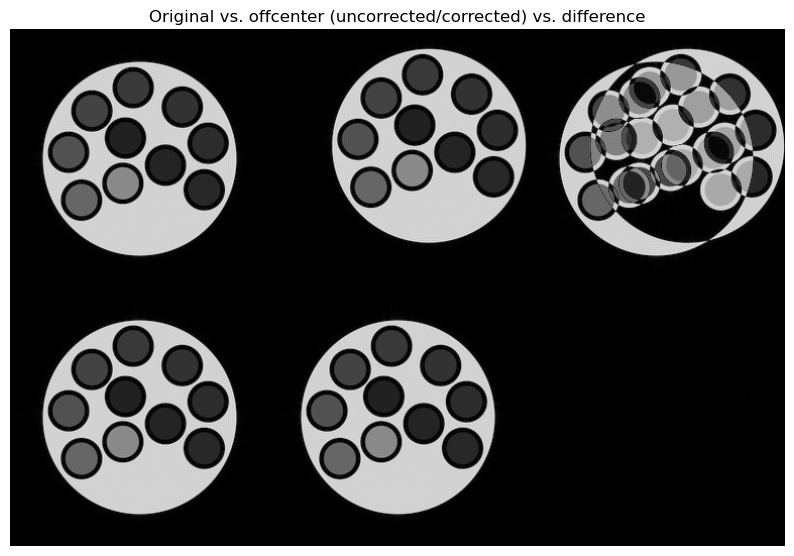

In [21]:
! bart saxpy -- -1 img img_offcenter	img_diff1
! bart saxpy -- -1 img img_corr 	img_diff2

! bart join 1 img img_offcenter img_diff1 img1
! bart join 1 img img_corr 	img_diff2 img2

! bart join 0 img1 img2 img

show_img(cfl.readcfl('img'), title='Original vs. offcenter (uncorrected/corrected) vs. difference')

## Reconstruction

A complete tutorial for creating and reconstructing phantom data can be found in the [1st BART Webinar Materials](https://github.com/mrirecon/bart-webinars/blob/master/webinar1/day1_advanced_recon.ipynb)

We start with a simple example that already demonstrates some useful functions in BART:

- Creation of synthetic k-space data using the `phantom` tool
- Calibration of sensitivities using NLINV using the `ncalib` tool
- Parallel imaging reconstruction using the `pics` tool

On the first step, we will create synthetic multi-coil k-space data using the `phantom` tool. We use the '-k' option to specify that we want to simulate k-space data, -s to set the number of coils. Further dimensions, such as readout and phase-encoding, are specified by the trajectory.

Set total number of spokes to 99 (full frame for RAGA encoding)
loops: 88209 	 dims: [  1  99   1   1   1   1   3   3  99   1   1   1   1   1   1   1 ]
kernels: 99 	 dims: [  1  99   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1


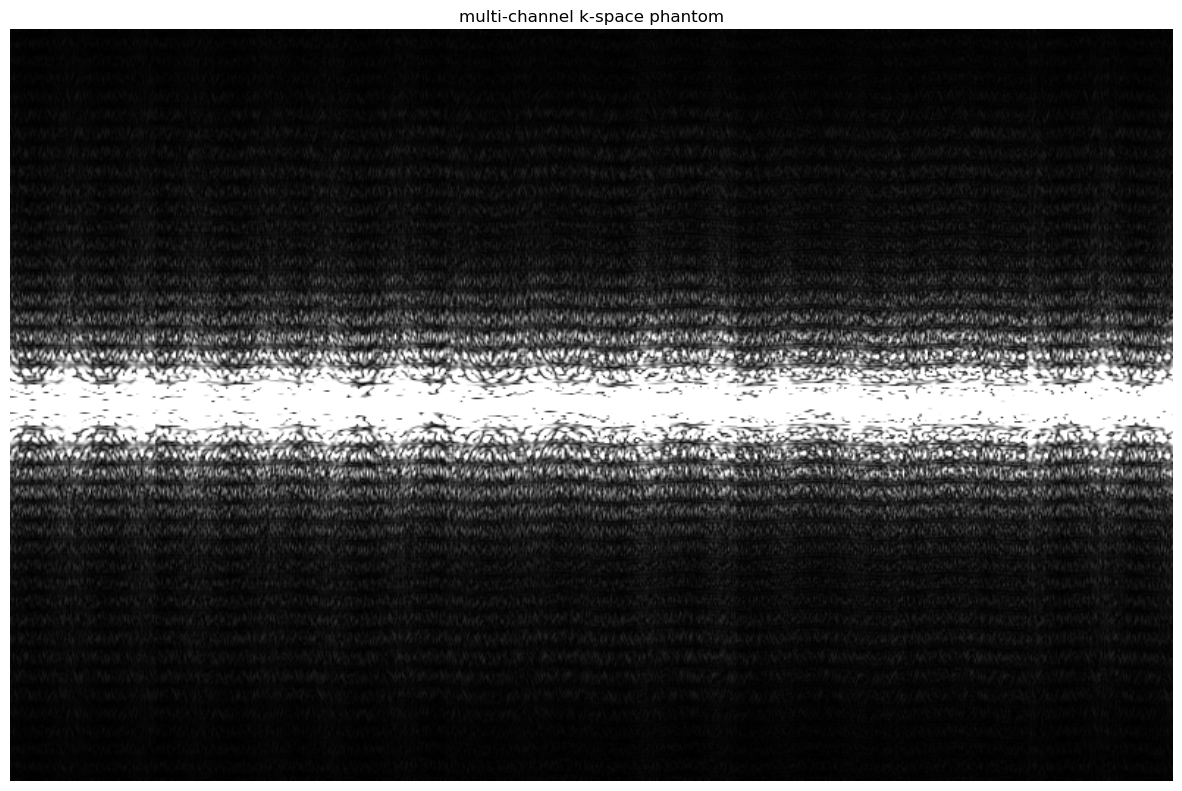

In [22]:
# create undersampled non-Cartesian multi-coil phantom in k-space
! bart seq -r99 --raga adc_us grad moments
! bart extract 0 0 3 adc_us seq_traj_us

! bart phantom -k '-s8' -T -b -t seq_traj_us basis_geom2
! bart fmac -s 64 basis_geom2 simu ksp_us

! bart reshape $(bart bitmask 2 3) $((8 * 99)) 1 ksp_us - | bart transpose 0 1 - - | bart transpose 1 2 - ksp_usR
show_img(cfl.readcfl('ksp_usR'), title='multi-channel k-space phantom', vmax=50, fsize=15)

After creating the undersampled data, we now first perform a simple reconstruction using a non-uniform inverse Fourier transform (`nufft`) and root-sum-of-squares coil combination (`rss`).

Est. image size: 256x256x1


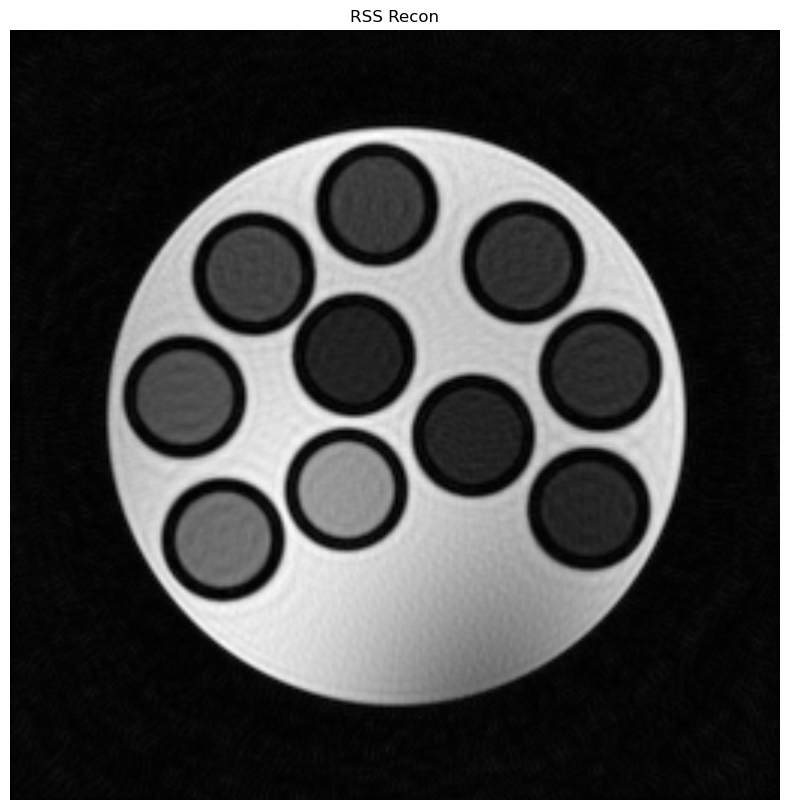

In [23]:
# simple nuFFT + RSS reconstruction

# perform inverse nuFFT.
! bart nufft -i seq_traj_us ksp_us img_us

# RSS-combine
! bart rss $(bart bitmask 3) img_us img_rss

show_img(cfl.readcfl('img_rss'), title='RSS Recon')

The result is (of course) not very good. The image is corrupted with noise and streaking artifacts due to the radial undersampling.

Let's try a more advanced reconstruction technique. We will first determine the coil sensitivities. Here, we use the NLINV/ENLIVE algorithm to obtain the sensitivity maps for each coil. We will now have a closer look at the `ncalib` tool.



Uecker M, Hohage T Block KT, Frahm J. Image reconstruction by regularized nonlinear inversion-joint estimation of coil sensitivities and image content. Magn Reson Med. 2008;60(3):674-82.

Holme HCM, Rosenzweig S, Ong F, Wilke RN, Lustig M, Uecker M. ENLIVE: An Efficient Nonlinear Method for Calibrationless and Robust Parallel Imaging. Sci Rep. 2017;

In [24]:
! bart ncalib -h

Usage: ncalib [-g] [-t <file>] [-p <file>] [-B <file>] [-r d:d:d] [-i d] [-o] [-N] [-m d] [-x,--dims d:d:d] [--shared-img-dims d] [--shared-col-dims d] [--scale-loop-dims d] [--phase-pole d] <kspace> <sensitivities> [<image (roughly scaled to rss of lowres k-space)>] 

Estimate coil sensitivities using ENLIVE calibration.

-g                         use gpu
-t file                    kspace trajectory
-p file                    kspace pattern
-B file                    subspace basis
-r cal_size                Limits the size of the calibration region.
-i iter                    Number of Newton steps
-o                         return oversampled coils
-N                         Normalize coil sensitivities
-m nmaps                   Number of ENLIVE maps to use in reconstruction
-x,--dims x:y:z            Explicitly specify sens dimensions
--shared-img-dims flags    deselect image dims with flags
--shared-col-dims flags    deselect coil dims with flags
--scale-loop-dims flags    scale

We normalize coil sensitivities in this example by using the option `-N`.

Est. image size: 256 256 1


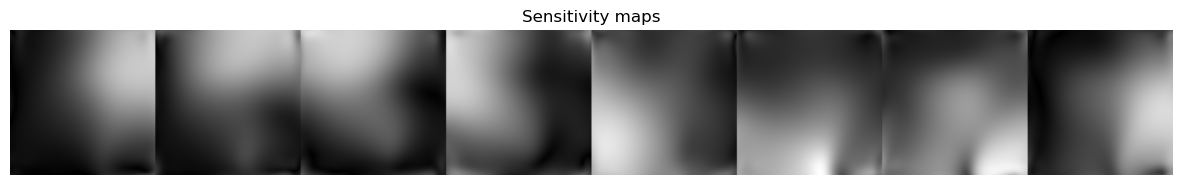

In [25]:
# compute sensitivity maps with NLINV
! bart ncalib -N -t seq_traj_us ksp_us sens_maps

! bart reshape $(bart bitmask 1 3) $((8 * 256)) 1 sens_maps sens_mapsR
show_img(cfl.readcfl('sens_mapsR'), title='Sensitivity maps', fsize=15)

Given the sensitivities, we can use the `pics` command to perform iterative parallel imaging reconstruction using various regularization terms. It solves the folllowing minimization problem:

$\arg\min_x ||PFS x - y|| + \alpha R(x)$, where:
- $P$ is the sampling operator
- $F$ is the Fourier transform
- $S$ is the multiplication with the sensitivity maps
- $x$ is the unknown image
- $y$ are the acquired multi-coil k-space data
- $R$ is a regularization functional
- $\alpha$ is the regularization weighting parameter

A popular regularization is $\ell_1$ wavelet , i.e. $R(x) = ||Wx||_1$.

The objective function then corresponds to a CS-SENSE reconstruction.


Pruessmann KP, Weiger M, Boernert P, Boesiger P. Advances in sensitivity encoding with arbitrary k-space trajectories. Magn Reson Med 2001; 46:638-651.

Lustig M, Donoho D, Pauly JM. Sparse MRI: The application of compressed sensing for rapid MR imaging. Magn Reson Med 2007; 58:1182-1195.

Block KT, Uecker M, Frahm J. Undersampled radial MRI with multiple coils. Iterative image reconstruction using a total variation constraint. Magn Reson Med 2007; 57:1086-1098.

In [26]:
! bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [--gpu-gridding] [-p <file>] [--precond] [-b d] [-e] [--adaptive-stepsize] [--asl] [--teasl] [--theta f:f] [--tvscales [f:]*f] [--tvscales2 [f:]*f] [--alpha f:f] [--gamma f:f] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-I,--ist] [--fista] [--eulermaruyama] [-m,--admm] [-a,--pridu] [-w f] [-S] [--shared-img-dims d] [-K] [-B <file>] [-P f] [-M] [-U,--lowmem] [--psf_export <file>] [--psf_import <file>] [--wavelet <string>] [--mpi d] [--fista_pqr f:f:f] [--ist_last] [--motion-field <file>] [--nufft-conf ...] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.


-l1/-l2                    toggle l1-wavelet or l2 regularization.
-r lambda                  regularization parameter
-R <T>:A:B:C               generalized regularization options (-Rh for help)
-c                         real-value constraint
-s step                    iteration stepsize
-i iter                    m

[  1 512  99   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
Maximum eigenvalue: 1.32e+02
l1-wavelet regularization: 0.001000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 3.170960


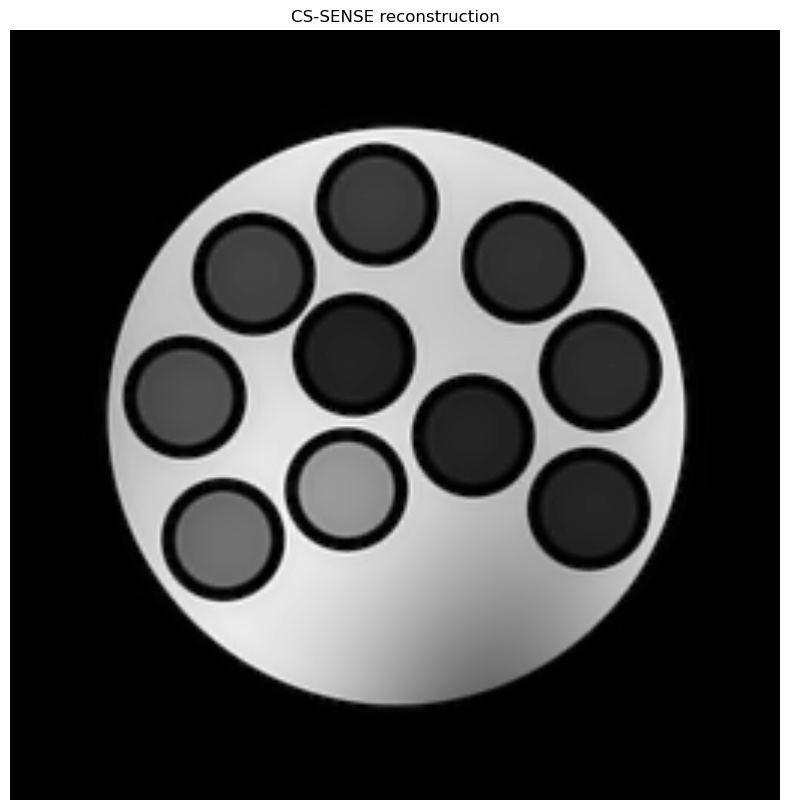

In [27]:
# parallel imaging reconstruction using l1 regularization; -e Scale stepsize based on max. eigenvalue; 
! bart pics -S -e -l1 -r 0.001 -i 50 -t seq_traj_us ksp_us sens_maps img_l1

show_img(cfl.readcfl('img_l1'), 'CS-SENSE reconstruction')

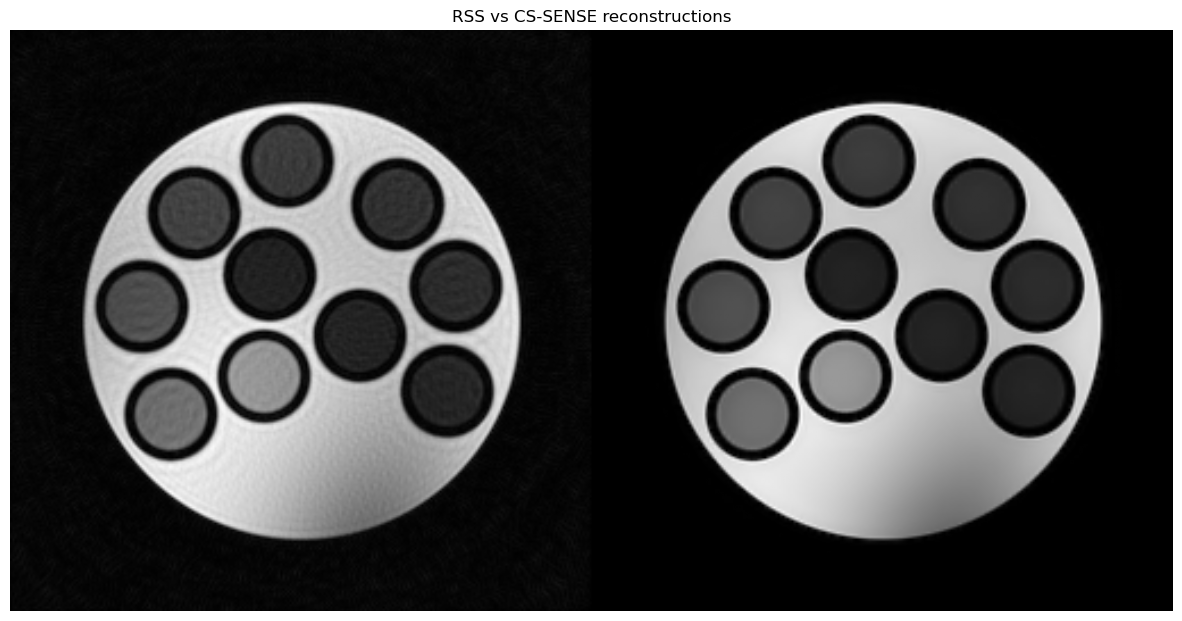

In [28]:
# combine images for display
! bart join 1 img_rss img_l1 img2

show_img(cfl.readcfl('img2'), title='RSS vs CS-SENSE reconstructions', fsize=15)

## Data acquisition with BART / pulseq

The sequence can also be saved in pulseq format, including metadata such as ADC labels and triggering information.
Data can then be acquired with vendor-specific pulseq interpreters.

Kelvin J. Layton, Stefan Kroboth, Feng Jia, Sebastian Littin, Huijun Yu, Jochen Leupold, Jon-Fredrik Nielsen, Tony Stöcker, Maxim Zaitsev. Pulseq: A rapid and hardware-independent pulse sequence prototyping framework Magn Reson Med 2017; 77:1544-1552.


In [29]:
! bart seq --TE 2e-3 --TR 3.5e-3 -r3 --FOV 0.256 --BR 256 adc grad moments three_spokes.seq

Set total number of spokes to 3 (full frame for RAGA encoding)
loops: 81 	 dims: [  1   3   1   1   1   1   3   3   3   1   1   1   1   1   1   1 ]
kernels: 3 	 dims: [  1   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1



Let us check the *.seq* file

<!-- Inconsistencies in offcenter measurements can be corrected retrospectively by adding the measured FOV-shift to the BART command and adding this phase information to the data in a preprocessing step. -->

In [30]:
! head -n30 three_spokes.seq

# Pulseq sequence file
# Created by BART v0.9.00-1413-g88bade9
# bart seq --TE 2e-3 --TR 3.5e-3 -r3 --FOV 0.256 --BR 256 adc grad moments three_spokes.seq 

[VERSION]
major 1
minor 4
revision 2

[DEFINITIONS]
AdcRasterTime 1e-07
BlockDurationRaster 1e-05
GradientRasterTime 1e-05
RadiofrequencyRasterTime 1e-06
FOV 0.256 0.256 0.006 
PhaseResolution 1.0 
TotalDuration 0.01050


# Format of blocks:
# NUM DUR RF  GX  GY  GZ  ADC  EXT
[BLOCKS]
   1 350 1 0 1 2 1 1
   2 350 2 3 4 2 2 2
   3 350 3 5 4 2 3 3

[ADC]
1 512 2000 1987 0.000000 2.371334
2 512 2000 1987 -0.000000 6.134966
3 512 2000 1987 0.000000 1.496661


We can print the sequence plot using `pypulseq`.

Installation of the python package will be done in the first cell.

In [31]:
! pip install pypulseq

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.13/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

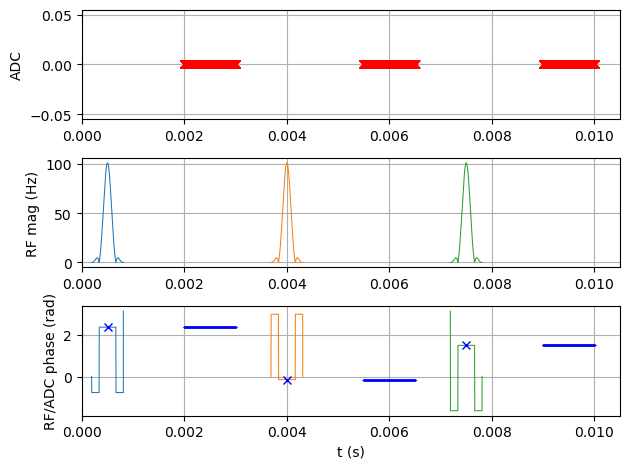

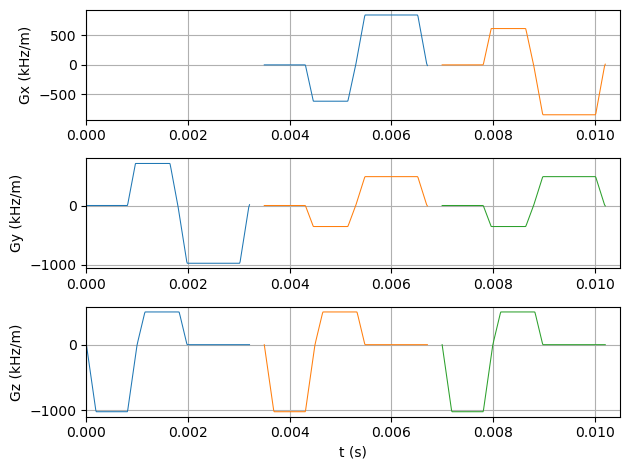

In [32]:
import pypulseq as pp

seq = pp.Sequence()
seq.read('three_spokes.seq')
seq.plot()

For a meaningful acquisition, we have to adjust the number of radial spokes and frames.

In [33]:
! bart seq --FOV 0.256 --BR 256 -r 377 --dwell 10e-6 --FA 50 --raga --TR 250e-3 --TE 3e-3 samples grad mom pulseq.seq 

Set total number of spokes to 377 (full frame for RAGA encoding)
loops: 1279161 	 dims: [  1 377   1   1   1   1   3   3 377   1   1   1   1   1   1   1 ]
kernels: 377 	 dims: [  1 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1


## BONUS: Reconstruction of data aquired by the scanner

Because the BART file format is simple, it is possible to read data from many different sources. The BART command includes the `twixread` tool for basic reading of Siemens `.dat` files. We also include GE Orchestra libraries for reading P-File and ScanArchives, called [ox-bart](https://github.com/mrirecon/ox-bart).

In the data folder, we have already converted a k-space dataset from a vendor-specific format to BART format.

Here, `ksp` is a single full RAGA frame. `noise` is a single measurement line without excitation, eg. a noise adjustment scan.

By using `-r1` we read data in a non-Cartesian manner, eg. a singleton dimension (dim 0), readout in dimension 1, and spokes in dimension 2.


In [34]:
%%bash

# bart twixread -A -r1 pulseq.dat ksp
# bart twixread -A     noise.dat  noise


if $COLAB; then

	mkdir data
	cd data
	rm ksp.{cfl,hdr} noise.{cfl,hdr}
	wget https://raw.githubusercontent.com/mrirecon/bart-workshop/refs/heads/master/mri_together_2025/data/ksp.hdr
	wget https://raw.githubusercontent.com/mrirecon/bart-workshop/refs/heads/master/mri_together_2025/data/ksp.cfl
	wget https://raw.githubusercontent.com/mrirecon/bart-workshop/refs/heads/master/mri_together_2025/data/noise.hdr
	wget https://raw.githubusercontent.com/mrirecon/bart-workshop/refs/heads/master/mri_together_2025/data/noise.cfl
	cd ..
fi

echo "ksp:"
# use the show command to display dimensions
bart show -m data/ksp

echo "noise:"
# use the show command to display dimensions
bart show -m data/noise




ksp:
Type: complex float
Dimensions: 16
AoD:	1	512	377	16	1	1	1	1	1	1	1	1	1	1	1	1
noise:
Type: complex float
Dimensions: 16
AoD:	256	1	1	16	1	1	1	1	1	1	1	1	1	1	1	1


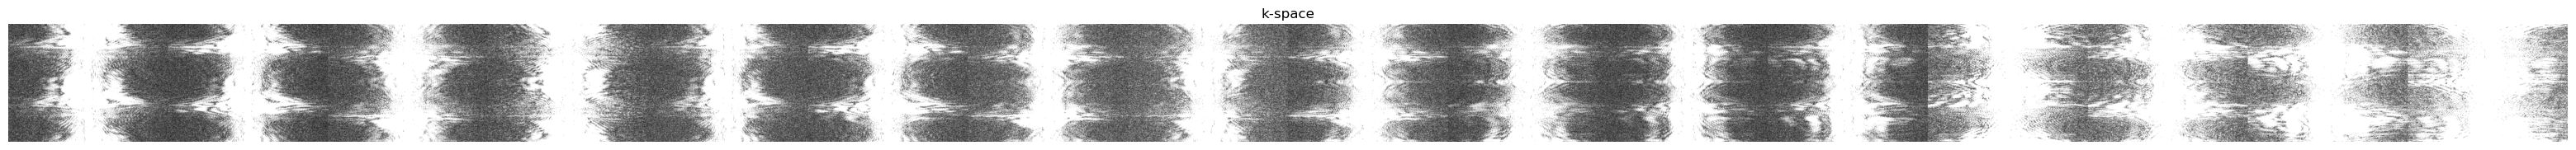

In [35]:
! bart reshape $(bart bitmask 1 3) $((16 * 512)) 1 data/ksp - | bart transpose 0 2 - kspR # only for visualization
show_img(cfl.readcfl('kspR'), title='k-space', vmax=.00001, fsize=40)

Based on the array sizes and dimensions, we can infer that the readout dimension is 512 samples, 377 acquired lines, and there are 16 coils.

#### Noise prewhitening & Coil Compression

Before reconstruction, it is a good idea to do noise pre-whitening. Most vendors should provide you with a noise pre-scan. If not, then you should complain to your vendor!

For more information about pre-whitening, check out the [ISMRM 2015 Sunrise Course on The Image Reconstruction Pipeline](http://hansenms.github.io/sunrise/) by Michael Hansen.

First, let us check the noise covariance matrix.

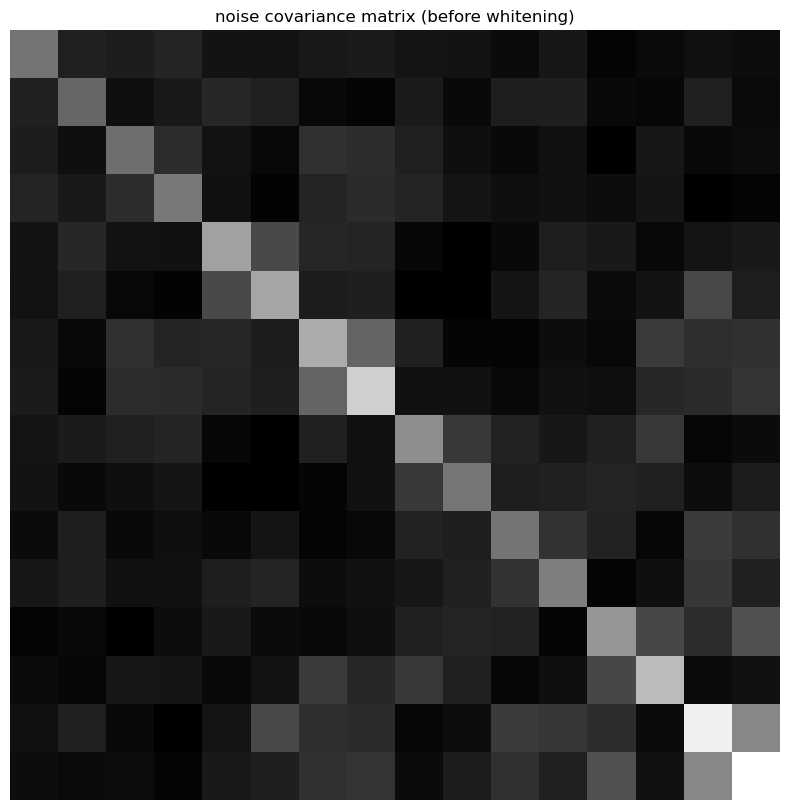

In [36]:
! bart transpose 3 4 data/noise noiseT 
! bart fmac -C -s 1 data/noise noiseT cov_tmp
! bart squeeze cov_tmp cov

show_img(cfl.readcfl('cov'), title='noise covariance matrix (before whitening)', interpolation='nearest')


We can use the BART `whiten` tool to apply a noise prewhitening matrix on noise scan itself.

Now, the covariance matrix is a unit matrix.


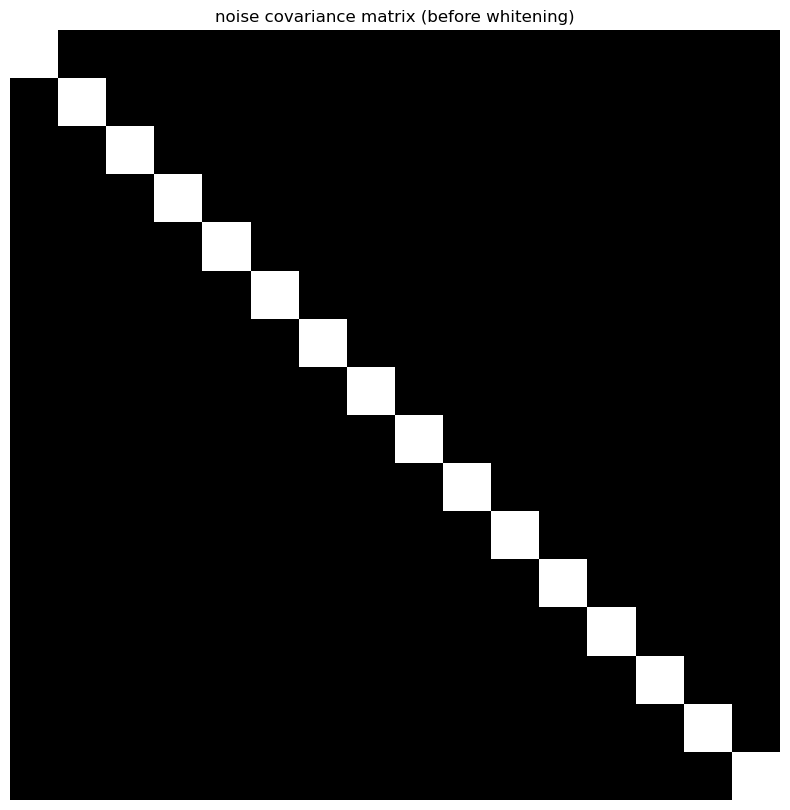

In [37]:
! bart whiten -n data/noise data/noise noise_white
! bart transpose 3 4 noise_white - | bart fmac -C -s 1 noise_white - - | bart squeeze - cov_white

show_img(cfl.readcfl('cov_white'), title='noise covariance matrix (before whitening)', interpolation='nearest')


We use the BART `whiten` tool to apply a noise prewhitening matrix on the k-space.

In [38]:

! bart whiten -n data/ksp data/noise ksp_white


To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command.

We will do coil compression in 2 steps. We will first use `cc` on the reference data to create the coil compression matrix. We will then use ``ccapply` to apply it to both the reference data and to the k-space data. This way we use the same coil compression matrix for both arrays.

By passing `-A` we choose to use all possible data and to reduce the dataset to 8 virtual coils with `-p`.


In [39]:
! bart cc -h

Usage: cc [-p d] [-M] [-r d:d:d] [-A] [-S] [-G] [-E] <kspace> <coeff|proj_kspace> 

Performs coil compression.

-p N    perform compression to N virtual channels
-M      output compression matrix
-r S    size of calibration region
-A      use all data to compute coefficients
-S      type: SVD
-G      type: Geometric
-E      type: ESPIRiT
-h      help


In [40]:
%%bash

bart cc -A -M ksp_white cc_mat
bart ccapply -p 8 ksp_white cc_mat ksp_cc_white

bart show -m ksp_cc_white


Type: complex float
Dimensions: 16
AoD:	1	512	377	8	1	1	1	1	1	1	1	1	1	1	1	1


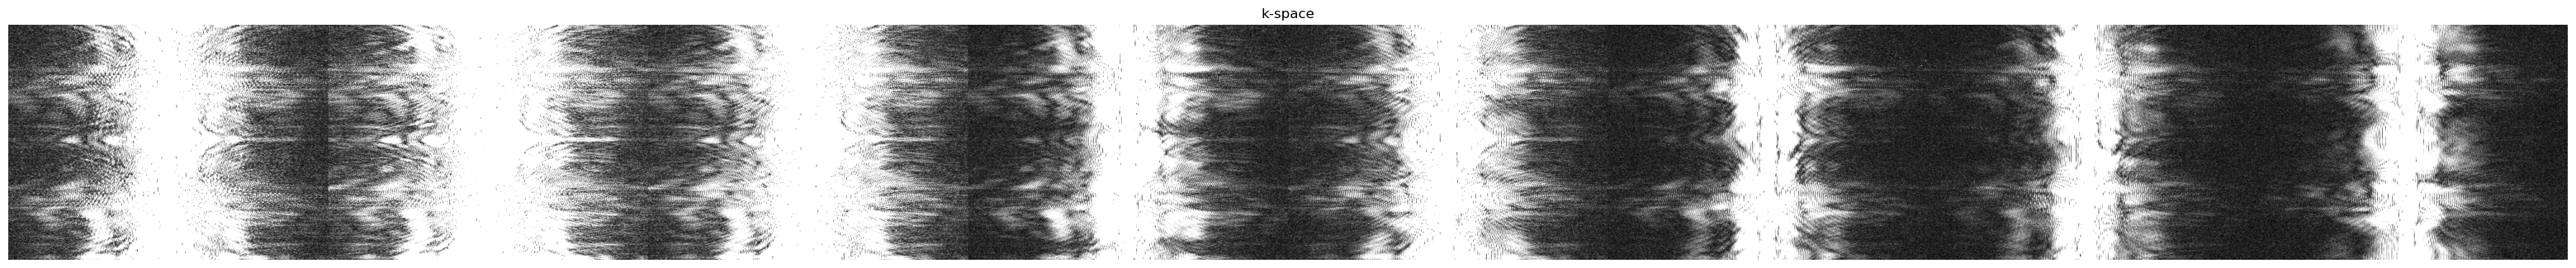

In [41]:
! bart reshape $(bart bitmask 1 3) $((8 * 512)) 1 ksp_cc_white - | bart transpose 0 2 - kspR # only for visualization
show_img(cfl.readcfl('kspR'), title='k-space', vmax=5, fsize=40)

#### Trajectory

As shown above, the commandline for generation of the sequence is stored in the *pulseq*-file.
So by running the command, we can regenerate the trajectory.

For our in-house vendor sequence, where BART is integrated as a dynamic linked library, we recover UI/system parameters from the raw-data and generate a *seq* command.


In [42]:
! head data/pulseq.seq

# Pulseq sequence file
# Created by BART v0.9.00-1413-g88bade9
# bart seq --FOV 0.256 --BR 256 -r 377 -f 1 --dwell 10e-6 --FA 50 --raga --spoiled --TR 250e-3 --TE 3e-3 samples grad mom pulseq.seq 

[VERSION]
major 1
minor 4
revision 2

[DEFINITIONS]


In [43]:
%%bash
bart seq --FOV 0.256 --BR 256 -r 377 -f 1 --dwell 10e-6 --FA 50 --raga --spoiled --TR 250e-3 --TE 3e-3 samples grad mom pulseq.seq 
bart show -m samples

bart vec 1 1 0 a # set z-component exact to zero
bart extract 0 0 3 samples - | bart fmac - a seq_traj

loops: 1279161 	 dims: [  1 377   1   1   1   1   3   3 377   1   1   1   1   1   1   1 ]
kernels: 377 	 dims: [  1 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Nr. of RF shapes: 1


Type: complex float
Dimensions: 16
AoD:	5	512	377	1	1	1	1	1	1	1	1	1	1	1	1	1


#### Gradient delay correction


Rosenzweig S, Holme HCM, Uecker M. Simple Auto-Calibrated Gradient Delay Estimation From Few Spokes Using Radial Intersections (RING). Magn Reson Med 2019; 81:1898-1906. https://gitlab.tugraz.at/ibi/mrirecon/papers/ring

In [44]:
! bart estdelay -R seq_traj ksp_cc_white gd
! bart show gd
! bart trajcor -V gd -O seq_traj seq_traj_gd

-1.605317e-01+0.000000e+00i	-1.894245e-01+0.000000e+00i	-5.941419e-02+0.000000e+00i


#### Coil sensitivity estimation


In [45]:
# estimate coil sensitivities
! bart ncalib -N -t seq_traj_gd ksp_cc_white sens_maps

Est. image size: 256 256 1


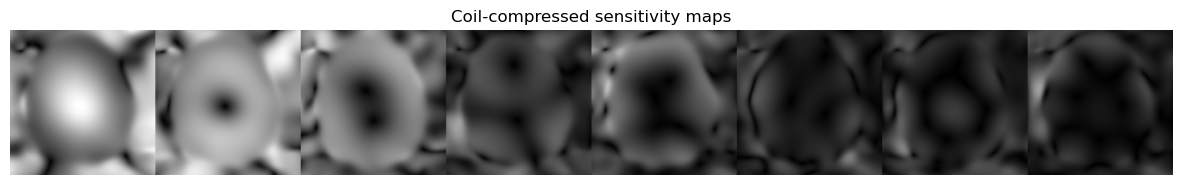

In [46]:
# display the coils
! bart transpose 0 1 sens_maps - | bart flip 1 - -  | bart reshape $(bart bitmask 1 3) $((8 * 256)) 1 - sens_mapsR
show_img(cfl.readcfl('sens_mapsR'), title='Coil-compressed sensitivity maps', fsize=15)

#### Parallel imaging reconstruction
We again use `pics` with l2 regularization. This time we pass an approximate scale factor directly to the `pics` command.

In [47]:
! bart pics -d4 -Se -l1 -i50 -r 3e-5 -t seq_traj_gd ksp_cc_white sens_maps reco

[  1 512 377   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512 377   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 377   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 377   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 377   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 13277.192383  (max = 14382.495117/p90 = 13277.192383/median = 5073.395996)
Inverse scaling of the data: 13277.192383
Maximum eigenvalue: 3.739484e+02
Maximum eigenvalue: 3.74e+02
l1-wavelet regularization: 0.000030
Regularization terms:

#### Visualize reconstruction

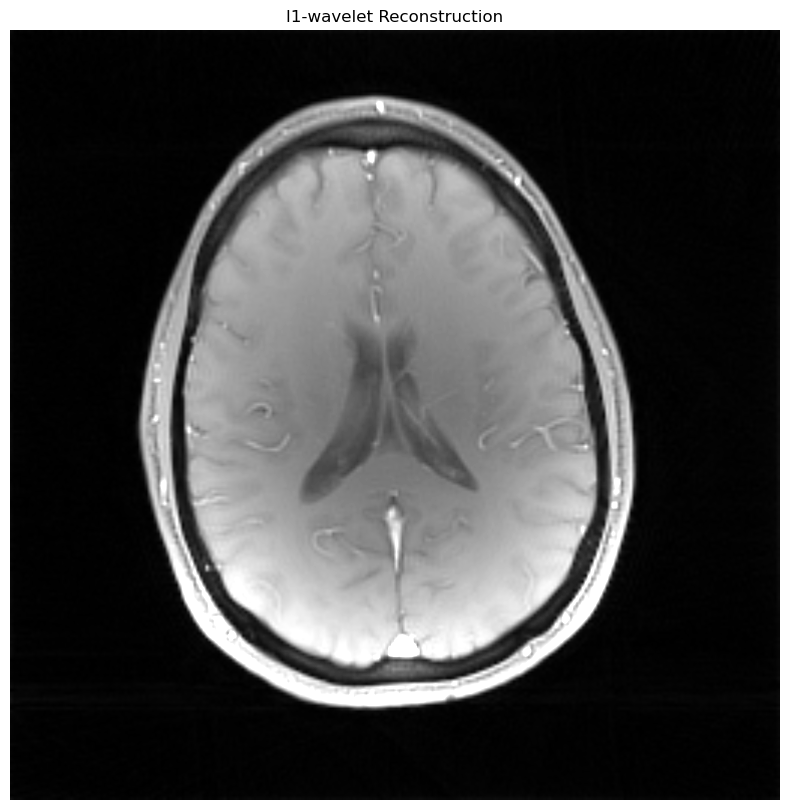

In [48]:
! bart transpose 0 1 reco - | bart flip 1 - reco2
show_img(cfl.readcfl('reco2'), title='l1-wavelet Reconstruction', vmax=80)

Thank you for your attention!